In [3]:
import json
import numpy as np
import pandas as pd
import cv2
import os
import scipy.misc
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.models import Model
from keras.utils import np_utils
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy import stats, integrate
from skimage import io,img_as_float
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

Using TensorFlow backend.


In [4]:
# GLOBAL CONSTANTS
DATA_FILE = 'leafsnap-dataset-images.csv'
NUM_CLASSES = 185
NB_EPOCH = 15
VGG_WEIGHTS_FILE = 'vgg16_weights.h5'

In [5]:
columns = ['file_id', 'image_pat', 'segmented_path', 'species', 'source']
data = pd.read_csv(DATA_FILE, names=columns, header=1)
display(data.head())

,file_id,image_pat,segmented_path,species,source
0,55498,dataset/images/lab/abies_concolor/ny1157-01-2.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
1,55499,dataset/images/lab/abies_concolor/ny1157-01-3.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
2,55500,dataset/images/lab/abies_concolor/ny1157-01-4.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
3,55501,dataset/images/lab/abies_concolor/ny1157-02-1.jpg,dataset/segmented/lab/abies_concolor/ny1157-02...,Abies concolor,lab
4,55502,dataset/images/lab/abies_concolor/ny1157-02-2.jpg,dataset/segmented/lab/abies_concolor/ny1157-02...,Abies concolor,lab


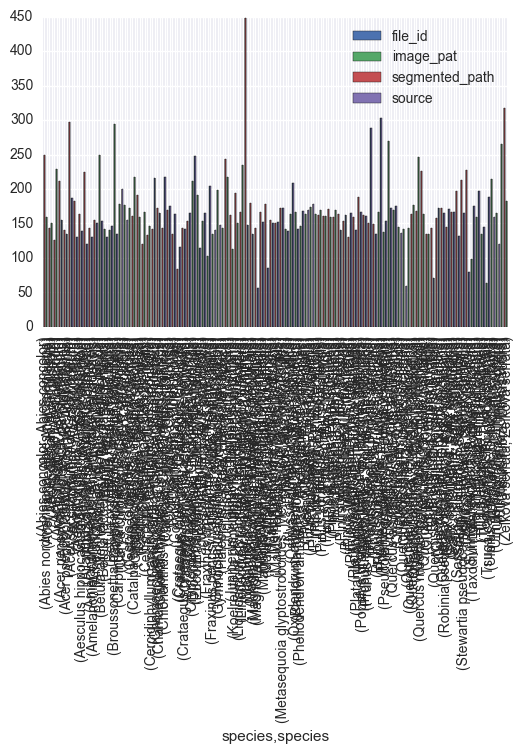

In [6]:
data.groupby([data['species'], 'species']).count().plot(kind='bar')

In [7]:
images_train, images_validation, species_train, species_validation = train_test_split(
    data['image_pat'], data['species'], test_size=0.25, random_state=42)

In [8]:
encoder = LabelEncoder()
encoder.fit(species_train)
species_train = encoder.transform(species_train)
species_train = np_utils.to_categorical(species_train)
species_validation = encoder.transform(species_validation)
species_validation = np_utils.to_categorical(species_validation)

In [9]:
def load_image_and_preprocess(path, flip_left_right=False, flip_up_down=False, rotate_180=False):
    # Open image from disk and flip it if generating data.
    image = Image.open(path.strip())

    if flip_left_right:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    if flip_up_down:
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    if rotate_180:
        image = image.transpose(Image.ROTATE_180)

    # Convert the image into mulitdimensional matrix of float values (normally int which messes up our division).
    image = np.array(image, np.float32)
    image = (image/127.5)-1.0
    # Resize Image
    image = scipy.misc.imresize(image, (224,224))
    # Return the modified image.
    return image

dataset/images/field/acer_palmatum/13001152968502.jpg


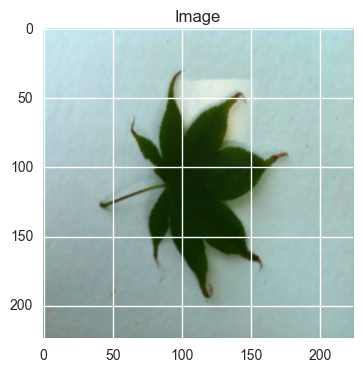

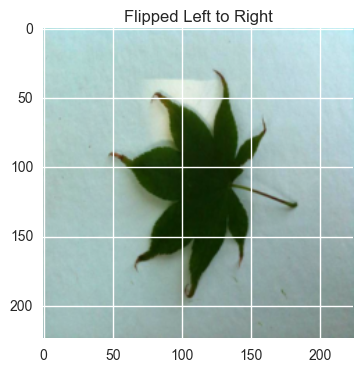

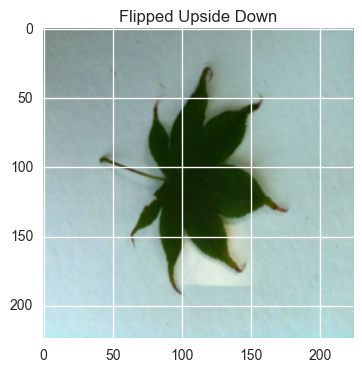

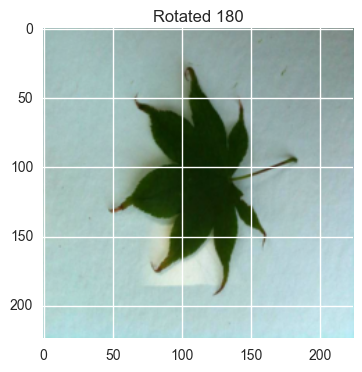

In [10]:
path = images_train[1040]
print(path)

image = load_image_and_preprocess(path)
_ = plt.imshow(image)
plt.title('Image')
plt.show()

flipped_left_right_image = load_image_and_preprocess(path,flip_left_right=True)
_ = plt.imshow(flipped_left_right_image)
plt.title('Flipped Left to Right')
plt.show()

flipped_up_down_image = load_image_and_preprocess(path,flip_up_down=True)
_ = plt.imshow(flipped_up_down_image)
plt.title('Flipped Upside Down')
plt.show()

rotated_180_image = load_image_and_preprocess(path,rotate_180=True)
_ = plt.imshow(rotated_180_image)
plt.title('Rotated 180')
plt.show()

In [11]:
def batch_generator(images, species, batch_size=64, augment_data=True):
    # Create an array of sample indices.
    batch_images = []
    batch_species = []
    sample_count = 0
    indices = np.arange(len(images))

    while True:
        # Shuffle indices to minimize overfitting. Common procedure.
        np.random.shuffle(indices)
        for i in indices:
            path = images.iloc[i]
            original_species = species[i]

            image = load_image_and_preprocess(path)
            batch_images.append(image)
            batch_species.append(original_species)

            # Add augmentation if needed. We do this because our model is only training on plai
            # images and we want as much data as possible.
            if augment_data:
                # Flip the image left right, up down, and rotated 180 to augment data
                flipped_left_right_image = load_image_and_preprocess(path,flip_left_right=True)
                batch_images.append(flipped_left_right_image)
                batch_species.append(original_species)

                flipped_up_down_image = load_image_and_preprocess(path,flip_up_down=True)
                batch_images.append(flipped_up_down_image)
                batch_species.append(original_species)

                rotated_180_image = load_image_and_preprocess(path,rotate_180=True)
                batch_images.append(rotated_180_image)
                batch_species.append(original_species)

            # Increment the number of samples.
            sample_count += 1

            # If we have processed batch_size number samples or this is the last batch
            # of the epoch, then we submit the batch. Since we augment the data there is a chance
            # we have more than the number of batch_size elements in each batch.
            if (sample_count % batch_size) == 0 or (sample_count % len(images)) == 0:
                yield np.array(batch_images), np.array(batch_species)
                # Reset
                batch_images = []
                batch_species = []

In [12]:
def VGG_16():
    base_model = VGG16(weights='imagenet', include_top=False)
                       
    for layer in base_model.layers:
        layer.trainable = False
        
    input = Input(shape=(224,224,3),name = 'image_input')
    output_vgg16_conv = base_model(input)
    
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(input=input, output=x)
    return model

In [13]:
samples_per_epoch = 4 * len(images_train)
generator_train = batch_generator(images_train, species_train, augment_data=True)
nb_val_samples = len(images_validation)
generator_validation = batch_generator(images_validation, species_validation, augment_data=False)

7717


In [14]:
model = VGG_16()
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
__________

/Users/sujith/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("im...)`


In [ ]:
history = model.fit_generator(generator_train,
                              steps_per_epoch=samples_per_epoch,
                              nb_epoch=NB_EPOCH,
                              validation_data=generator_validation,
                              validation_steps=nb_val_samples)